<h1><center>Physique numérique (PHY-3500)</center></h1>
<h1><center>TP1 - Intégration numérique</center></h1>

## Nom des membres de l'équipe:

### Nom, Prénom :  NI 
### Légaré, Ophélie : 111 182 608
### Parrot, Anaïs : 111 184 980
### Turgeon, David : 111 182 265

### Importation des modules :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as cte

# Introduction : 

La radiothérapie externe est une méthode employée notamment dans le domaine de la radio-oncologie au CHUM pour le traitement du cancer. La radiothérapie externe traite les tumeurs au moyen de faisceaux de rayons-X, d'électrons ou de hadrons. La protonthérapie, quant à elle, est une branche spécifique de la radiothérapie visant à traiter les tumeurs peu profondes telles que les mélanomes oculaires à l'aide de faisceaux de protons de faible énergie. Cette technique permet d'optimiser la ballistique du faisceau afin de cibler la tumeur tout en épargnant les tissus sains.

Dans cette étude, on cherche à planifier et prédire la dose reçue par un patient suivant un traitement de protonthérapie. Pour ce faire, la portée des protons dans la matière est déterminée à l'aide de méthodes d'intégration numérique, soit la méthode des trapèzes et la méthode de Simpson. Par la suite, les algorithmes sont comparés à une distribution de Moyal. Le calcul de l'énergie déposée par le faisceau de protons à la tumeur est réalisé à partir de son énergie cinétique. Finalement, le réalisme du modèle d'intégration numérique développé est discuté.

# Équations utiles :

Pouvoir d'arrêt collisionnel massique :

\begin{align}
\frac{S_{col}}{\rho} = -\left(\frac{dT}{\rho dx}\right) = NZ\int^{T_e^{max}}_0 T \left(\frac{d\sigma}{dT'}\right)_{col}dT'
\end{align}

L'énergie maximale transférable à un électron par le proton :

\begin{align}
T_e^{max} = \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}
\end{align}

Pouvoir d'arrêt collisionnel pour les protons :

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{Z^2}{\beta^2}\left [\ln\left(\frac{2m_e c^2(\gamma^2-1)T_e^{max}}{I^2} \right)-\delta+\\
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}

Pouvoir d'arrêt collisionnel pour protons de plus de 3 MeV (termes correctifs négligés) :

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]
\end{align}

Portée des protons en ligne droite dans la matière :

\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}}
\end{align}

Énergie déposée pour un déplacement d'un proton s dans un milieu :

\begin{align}
s = \int^{T_i}_{T_f} \frac{dT'}{S_{col}}
\end{align}

Les différentes variables utilisées sont :

- r_e le rayon classique de l'électron
- n_e la densité électronique du matériaux
- Z la charge de la particule (Z = 1 pour les protons)
- N le nombre d'atome par gramme
- T' l'énergie transféré à l'électron de l'atome
- I l'énergie moyenne d'excitation du matériau,
- $\frac{d\sigma}{dT}$ section efficace différentielle pour les collision inélastique d'une énergie transféee T',
- $\beta$ et $\gamma$ sont les facteurs de Lorentz,
- $\delta$ un terme considérant les effets de la polarisation,
- $2\frac{C}{Z}$ corrige les effet du modèle en couche du cortège électronique atomique
- ZL$_1$ est la correction de Barkas
- Z$^2$L$_2$ est la correction de Bloch


## Question 1 :

La densité électronique d'un milieu peut être exprimée en fonction de sa composition atomique et de sa masse volumique à l'aide de l'équation suivante :

\begin{align}
n_e = \frac{N_A Z \rho}{A M_u} = 0.6022~x~10^{24}~ \frac{Z \rho}{A},
\end{align}

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $\rho$ est la densité, $A$ est la masse atomique relative et $M_u$ est la  masse molaire. L'eau liquide et l'os compact (ICRU) sont des composés dont le numéro atomique et la masse atomique de chacun des éléments qui les composent sont pondérés selon leur fraction massique respective.

In [8]:
def densite_eau(rho,Z_1,A_1,Z_8,A_8):
    n_eau = (0.6022*10**(24))*rho*(0.111894*(Z_1/A_1)+0.888106*(Z_8/A_8))
    return n_eau
print(densite_eau(1.00000,1,1.00794,8,15.9994), "électrons par cm^3")

3.342705085983941e+23 électrons par cm^3


In [9]:
def densite_os(rho,Z_1,A_1,Z_6,A_6,Z_7,A_7,Z_8,A_8,Z_12,A_12,Z_15,A_15,Z_16,A_16,Z_20,A_20):
    n_os = (0.6022*10**(24))*rho*(0.063984*(Z_1/A_1)+0.278000*(Z_6/A_6)+0.027000*(Z_7/A_7)+0.410016*(Z_8/A_8)+0.002000*(Z_12/A_12)+0.070000*(Z_15/A_15)+0.002000*(Z_16/A_16)+0.147000*(Z_20/A_20))
    return n_os
print(densite_os(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078), "électrons par cm^3")

5.90576758009253e+23 électrons par cm^3


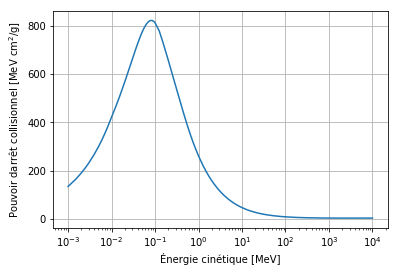

In [4]:
"""  PU BON!!!!!
water_energy = np.loadtxt("./eau.txt", float)
#print(water_energy)
plt.figure()
plt.plot(water_energy[:,0],water_energy[:,1])
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV cm$^2$/g]')
plt.grid(True)
plt.xscale('log')
plt.show()
"""

132


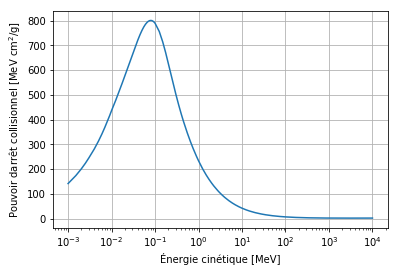

In [5]:
"""  PU BON!!!!!
bone_energy = np.loadtxt("./bone.txt", float)
print(len(bone_energy[:,1]))
plt.figure()
plt.plot(bone_energy[:,0],bone_energy[:,1])
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV cm$^2$/g]')
plt.grid(True)
plt.xscale('log')
plt.show()
"""

L'énergie moyenne d'excitation de l'eau liquide est de 75.000000 eV et celle de l'os compact (ICRU) est de 91.900000 eV. Les courbes des pouvoirs d'arrêt collisionnel de l'eau liquide et de l'os compact sont présentées ci-dessous avec une échelle logarithmique en abscisse.

In [49]:
# Les fonctions à intégrer tel que les facteur de Lorentz et le pouvoir d'arrêt collisionnelle S_col.

mp = cte.m_p # Masse du proton
me = cte.m_e  # Masse de l'électron
c = cte.c # Vitesse de la lumière dans le vide
r_e = cte.physical_constants["Bohr radius"][0]

def Lorentz_factor(T): # T pour énergie cinétique du proton        
    """ Code David pu bon!
    if v >= c: 
        "Évité que l'erreur se retrouve dans gamma (pour racine de 0 ou d'un nombre négatif)
            et ainsi indiqué l'énergie problématique"
        raise ValueError(f"The velocity of the proton at {E/(cte.e*1e6)} MeV is to great")
    
    beta = v/c
    gamma = 1/np.sqrt(1 - beta**2)
    """
    
    gamma = T/(mp * c**2) + 1
    beta = np.sqrt((gamma**2 - 1) / gamma**2)
    
    return gamma, beta

def T_e_max(gamma):  # en J
    numerateur = 2*me*c**2*(gamma**2-1)
    denominateur = 1+2*gamma*me/mp + (me/mp)**2
    
    return numerateur/denominateur

def pouvoir_arret(T, n_e, I):  # T et I en eV
    # Pour les protons de plus de 3 MeV
    T *= cte.e # Transformation de l'énergie en eV vers des J
    I *= cte.e # Transformation de l'énergie d'excitation en Ev vers des J
    gamma, beta = Lorentz_factor(T)
    Temax = T_e_max(gamma)
    
    arg_log = 2*me*c**2*beta**2*gamma**2*Temax/I**2
    S_col = 2*np.pi * (r_e*100)**2 * me*c**2 * n_e/beta**2 * (np.log(arg_log) - 2*beta**2)  # r_e mis en cm pour compenser n_e en cm^-3
    return S_col/cte.e  # Pour avoir S_col en eV/cm

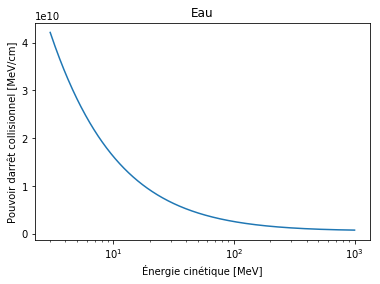

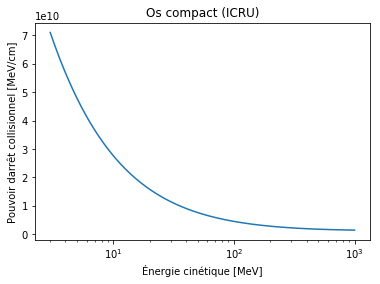

In [53]:
T = np.linspace(3, 1000, 10000)  # en MeV
plt.plot(T, pouvoir_arret(T*1e6, densite_eau(1.00000,1,1.00794,8,15.9994), 75)/1e6)
plt.title("Eau")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

T = np.linspace(3, 1000, 10000)  # en MeV
plt.plot(T, pouvoir_arret(T*1e6, densite_os(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078), 91.9)/1e6)
plt.title("Os compact (ICRU)")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

# Portée des protons dans la matière

## Question 2 :
BLABLATONS TOUS EN COEUUUUUUUURRRRRRRR!!!!!!!!!!

## Question 3 :

## Question 4 :
Il est nécessaire d'employer une méthode numérique pour calculer la portée des protons car il n'est pas possible de calculer cette dernière de façon analytique. On a donc recours à l'intégration numérique par la méthode des trapèzes et par la méthode de Simpson. Tel que présenté à la question 1, le pouvoir d'arrêt collisionnel varie en fonction de l'énergie des protons et du milieu traversé par le faisceau de protons. La portée des protons dépend entre autres des énergies de faisceau sélectionnées, de la forme et de la profondeur de la tumeur à traiter, de l'anatomie ainsi que de la morphologie spécifique du patient. Il s'agit de calculs complexes et laborieux qui nécessitent une exactitude au millimètre ou dixième de millimètre près afin de préserver les tissus sains. La calul numérique de la portée des protons permet d'économiser du temps lors de la préparation du traitement de chaque patient et de s'assurer que la ballistique du traitement est exacte et optimale.

## Question 5 :

Comme mentionné en introduction, deux méthodes d'intrégration seront utilisés ici : la méthode des trapèzes et la méthode de Simpson. Leur algorithme respectif est écrit ci-dessous.

In [7]:
def methode_trapezes(data, a, b, N):
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0
    
    index_a = np.where(data[:, 0] == a)[0][0]   
    index_b = np.where(data[:, 0] == b)[0][0]
    h = (b - a) / N
    return h * (1/2*data[index_a, 1] + 1/2*data[index_b, 1] + sum(data[index_a+1:index_b, 1]))


def methode_Simpson(data, a, b, N):
    # N doit être pair pour que ça fonctionne
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0
    
    index_a = np.where(data[:, 0] == a)[0][0]   
    index_b = np.where(data[:, 0] == b)[0][0]
    h = (b - a) / N
    
    somme_impaire = 0
    somme_paire = 0
    for i in range(1, N, 2):
        somme_impaire += data[index_a + i, 1]
    for i in range(2, N, 2):
        somme_paire += data[index_a + i, 1]
    
    return 1 / 3 * h * (data[index_a, 1] + data[index_b, 1] + 4 * somme_impaire + 2 * somme_paire)


# Pour tester les méthodes avec l'exemple 5.1 et l'exercice 5.2 du manuel :
"""
def f(x):
    return x**4 - 2*x + 1

dat = []
for x in np.linspace(0, 2, 11):
    dat.append([x, f(x)])
Z = np.asarray(dat)
print(methode_Simpson(Z, 0, 2, 10))
"""

'\ndef f(x):\n    return x**4 - 2*x + 1\n\ndat = []\nfor x in np.linspace(0, 2, 11):\n    dat.append([x, f(x)])\nZ = np.asarray(dat)\nprint(methode_Simpson(Z, 0, 2, 10))\n'

In [8]:
# Intégrer entre 3 et 150 MeV!
print(methode_trapezes(water_energy, 3.0, 150.0, 36))
print(methode_Simpson(water_energy, 3.0, 150.0, 36))

5467.503708333332
5434.937083333331


## Question 6 :

L'expression analytique de la dérivée du pouvoir d'arrêt collisionnel est obtenue avec les simplifications et substitutions suggérées dans l'énoncé. On obtient l'équation suivante.

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = U \frac{Z^2}{\beta^2}\left [\ln\left(\frac{k\gamma^4\beta^4}{\gamma\delta+b}\right)-\delta+
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}    

## Question 7 :

# Optimisation

# Énergie déposée